In [1]:
import os
import time
import sys
import h5py
import re
import tensorflow         as tf
import numpy              as np
import pandas             as pd
import matplotlib as mpl
from matplotlib           import pyplot as plt 
from os                   import path
from tqdm                 import tqdm
import seaborn                                as sns

print("========================================================")
print(" TensorFlow version: {}".format(tf.__version__))
print(" Eager execution: {}".format(tf.executing_eagerly()))

 TensorFlow version: 2.4.1
 Eager execution: True


In [2]:
pd.set_option('display.max_columns', None)  
sns.set_style('ticks')
plt.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \boldmath']
# plt.rc('text.latex', preamble=r'\usepackage{pifont} \usepackage{tikz} \usepackage[utf8]{inputenc}')
plt.rc('font', family='Times')
sns.set_context("paper")

# Tick parameters
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 10
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 10
mpl.rcParams['ytick.minor.width'] = 2

plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['legend.fontsize'] = 35

<ipython-input-2-5807b085ca32>:4: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \boldmath']


In [3]:
WORKSPACE_PATH      = os.environ['WORKSPACE_PATH']
SurQCTFldr          = WORKSPACE_PATH + '/SurQCT/surqct/'

SystemName          = 'O3_UMN' 
Dimension           = 'nondim'
RatesType           = 'KExcit'
RatesTypeHDF5       = 'Inel'
ExcitType           = 'KInel'
NNRunIdx            = 9
# RatesTypeHDF5       = 'Exch_1'
# ExcitType           = 'KExch'
# NNRunIdx            = 6

if(Dimension=='nondim'):
    PathToRunFld        = SurQCTFldr + '/../' + RatesType + '/all_temperatures_nondim/' + ExcitType + '/' 
elif(Dimension=='transfer'):
    PathToRunFld        = SurQCTFldr + '/../' + RatesType + '_N3_TransLearn/all_temperatures_nondim/' + ExcitType + '/'
    
TTranVec           = [8000]

MinRate             = 1.e-18

In [4]:
print("\n[SurQCT]: Loading Modules and Functions ...")

sys.path.insert(0, SurQCTFldr  + '/src/Reading/')
from Reading  import read_levelsdata, read_diatdata

InputFld = PathToRunFld + '/Run_' + str(NNRunIdx) + '/'
print(InputFld)
sys.path.insert(0, InputFld)


[SurQCT]: Loading Modules and Functions ...
/home/venturi/WORKSPACE//SurQCT/surqct//../KExcit/all_temperatures_nondim/KInel//Run_9/


In [5]:
print("\n[SurQCT]: Keep Loading Modules and Functions...")
from SurQCT_Input import inputdata

print("\n[SurQCT]: Initializing Input ...")
InputData    = inputdata(WORKSPACE_PATH, SurQCTFldr)

Prefix                    = 'Run_'
InputData.NNRunIdx        = NNRunIdx
InputData.PathToRunFld    = InputData.PathToRunFld+'/'+Prefix+str(InputData.NNRunIdx)
InputData.PathToFigFld    = InputData.PathToRunFld+'/'+InputData.PathToFigFld
InputData.PathToParamsFld = InputData.PathToRunFld+'/'+InputData.PathToParamsFld
InputData.PathToDataFld   = InputData.PathToRunFld+'/Data/'                                                               
InputData.PathToParamsFld = InputData.PathToRunFld+'/Params/' 
InputData.PathtoHDF5NN    = WORKSPACE_PATH  + '/Air_Database/HDF5_Database_NN/'+SystemName+'.hdf5'

OtherVar           = InputData.OtherVar
xVarsVec_i         = InputData.xVarsVec_i + ['vqn','jqn']
xVarsVec_Delta     = InputData.xVarsVec_Delta
xVarsVec           = list(set(xVarsVec_i) | set(xVarsVec_Delta))
print('[SurQCT]:   Reading Variables: ', xVarsVec)
NMolecules         = len(InputData.PathToLevelsFile)



[SurQCT]: Keep Loading Modules and Functions...

[SurQCT]: Initializing Input ...
[SurQCT]:   Reading Variables:  ['log_rorMin', 'log_EVib', 'jqn', 'log_ERot', 'ri', 'vqn']


In [6]:
import Initialize_System

Initialize = getattr(Initialize_System,'Initialize_'+SystemName)
InputData = Initialize(InputData,Dimension)

In [7]:
LevelsData = []
DiatData   = []
NLevels    = []
for iMol in range(NMolecules):

    LevelsDataTemp = read_levelsdata(InputData.PathToLevelsFile[iMol], xVarsVec, '')
    LevelsData.append(LevelsDataTemp)

    DiatDataTemp = read_diatdata(InputData.PathToDiatFile[iMol], InputData.Molecules[iMol], TTranVec, TTranVec)
    DiatData.append(DiatDataTemp)
    
    NLevelsTemp    = LevelsDataTemp.shape[0]
    NLevels.append(NLevelsTemp)


[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//Air_Database/Run_0D/database/levels/O2_UMN_log_nd.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/O2/UMN/FromUMN_Sorted.inp
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//Air_Database/Run_0D/database/levels/O2_UMN_log_nd.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/O2/UMN/FromUMN_Sorted.inp


In [8]:
#========================================================================================================
def read_kexcitdata(InputData, PathToHDF5File, TTra, TInt, NProcTypes):
    print('[SurQCT]:       Reading HDF5 File from: ' + PathToHDF5File + ' for Excitation Rates at Temperature ' + str(int(TTra)) + 'K')

    HDF5Exist_Flg = path.exists(PathToHDF5File)
    if (HDF5Exist_Flg):
        f = h5py.File(PathToHDF5File, 'a')
    else:
        f = {'key': 'value'}

    TStr = 'T_' + str(int(TTra)) + '_' + str(int(TInt)) + '/Rates/'
    grp  = f[TStr]

    Data  = grp["Inel"]
    KInel = Data[...] 


    return KInel

#========================================================================================================
def read_kexcitdata_surQCT(InputData, PathToHDF5File, TTra, TInt, NProcTypes):
    print('[SurQCT]:       Reading HDF5 File from: ' + PathToHDF5File + ' for Excitation Rates at Temperature ' + str(int(TTra)) + 'K')

    HDF5Exist_Flg = path.exists(PathToHDF5File)
    if (HDF5Exist_Flg):
        f = h5py.File(PathToHDF5File, 'a')
    else:
        f = {'key': 'value'}

    TStr = '/RunI' + str(int(NNRunIdx)) + '/T_' + str(int(TTra)) + '_' + str(int(TInt)) + '/Rates/'
    grp  = f[TStr]

    Data  = grp["Inel"]
    KInel = Data[...]

    f.close()   


    return KInel

In [9]:
for TTran in TTranVec:
    KInel    = read_kexcitdata(InputData, InputData.PathToHDF5File, TTran, TTran, 3)
    KInel_NN = read_kexcitdata_surQCT(InputData, InputData.PathtoHDF5NN,   TTran, TTran, 3)
    np.fill_diagonal(KInel, 0.0)
    np.fill_diagonal(KInel_NN, 0.0)
#     ErrorMat = abs(np.log10(KInel_NN)-np.log10(KInel)/np.log10(KInel))

[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 8000K
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database_NN/O3_UMN.hdf5 for Excitation Rates at Temperature 8000K


In [10]:
UnitOfMeasure = 27.211396641308
PlotLevelsData        = pd.read_csv(InputData.PathToDiatFile[0], delim_whitespace=True, skiprows=15, header=None)
PlotLevelsData.columns    = ['vqn','jqn','EInt','egam','rMin','rMax','VMin','VMax','Tau','ri','ro']    

### Energy reference is at the bottom of the well. 
PlotLevelsData['VMax']    = ( PlotLevelsData['VMax'].to_numpy() -  np.amin(PlotLevelsData['VMin'].to_numpy())) * UnitOfMeasure
PlotLevelsData['EInt']    = ( PlotLevelsData['EInt'].to_numpy() -  np.amin(PlotLevelsData['VMin'].to_numpy())) * UnitOfMeasure
PlotLevelsData['VMin']    = ( PlotLevelsData['VMin'].to_numpy() -  np.amin(PlotLevelsData['VMin'].to_numpy())) * UnitOfMeasure

VDiss                  = PlotLevelsData['VMax'].to_numpy()[0]
PlotLevelsData['EInt_diss']  = PlotLevelsData.EInt.to_numpy()  / VDiss


<ipython-input-11-3c677c4402ed>:6: RuntimeWarning: divide by zero encountered in log10
  axs[0].imshow(np.log10(KInel.transpose()),origin='lower', interpolation='none',vmin=vmin, vmax=vmax, extent=extent, cmap='jet')
<ipython-input-11-3c677c4402ed>:9: RuntimeWarning: divide by zero encountered in log10
  sc = axs[1].imshow(np.log10(KInel_NN.transpose()),origin='lower', interpolation='none',vmin=vmin, vmax=vmax, extent=extent,cmap='jet')


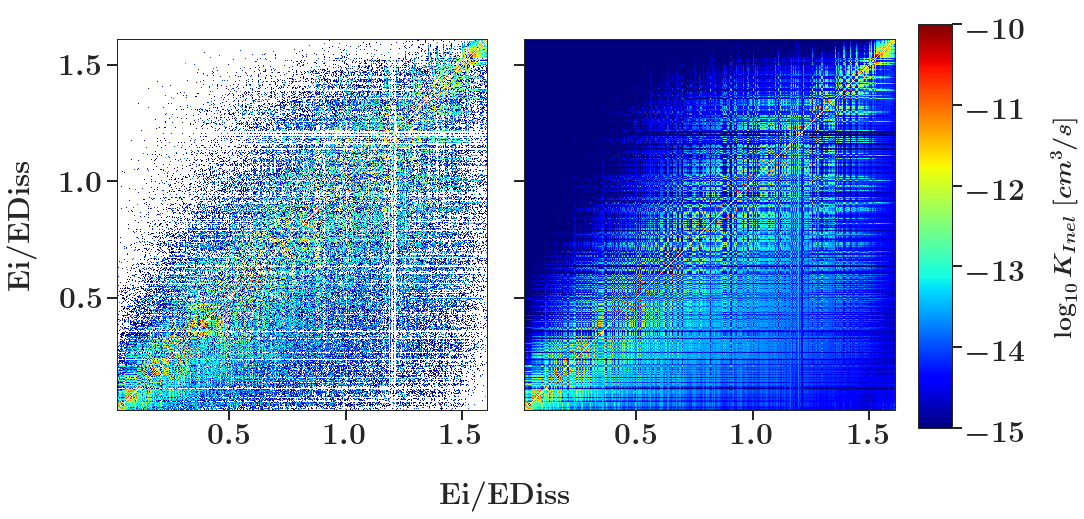

In [11]:
fig, axs = plt.subplots(1,2,sharey=True,sharex=True,figsize=(16,8))
vmin     = -15
vmax     = -10
KInel_NN_plt = KInel_NN.transpose()
extent=[PlotLevelsData['EInt_diss'].min(), PlotLevelsData['EInt_diss'].max(), PlotLevelsData['EInt_diss'].min(),PlotLevelsData['EInt_diss'].max()]
axs[0].imshow(np.log10(KInel.transpose()),origin='lower', interpolation='none',vmin=vmin, vmax=vmax, extent=extent, cmap='jet')
# axs[0].set_xlim([PlotLevelsData['EInt_diss'].min(),0.09])
# axs[0].set_ylim([PlotLevelsData['EInt_diss'].min(),0.09])
sc = axs[1].imshow(np.log10(KInel_NN.transpose()),origin='lower', interpolation='none',vmin=vmin, vmax=vmax, extent=extent,cmap='jet')
# axs[1].set_xlim([PlotLevelsData['EInt_diss'].min(),0.09])
# axs[1].set_ylim([PlotLevelsData['EInt_diss'].min(),0.09])

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xticks([])
plt.yticks([])
plt.xlabel('\\textbf{Ei/EDiss}',labelpad=40)
plt.ylabel('\\textbf{Ei/EDiss}',labelpad=80)

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.03, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label('$\log_{10}{K_{Inel}}$ \\textbf{[}$cm^3/s$\\textbf{]}', rotation=90,labelpad=25,size=25)
# plt.savefig(('/home/venturi/WORKSPACE/SurQCT/0D/Figures/O3_UMN/nondim_RunI9_E6_D55/T'+str(TTran)+'K_KInelMatrix.pdf'), format='pdf',dpi=1200)



<Figure size 432x288 with 0 Axes>

<ipython-input-12-6683fefb65a0>:5: RuntimeWarning: divide by zero encountered in log10
  sc = plt.imshow(np.log10(KInel.transpose()),origin='lower', interpolation='none',vmin=vmin, vmax=vmax, cmap='jet')


Text(0, 0.5, '\\textbf{Ei/EDiss}')

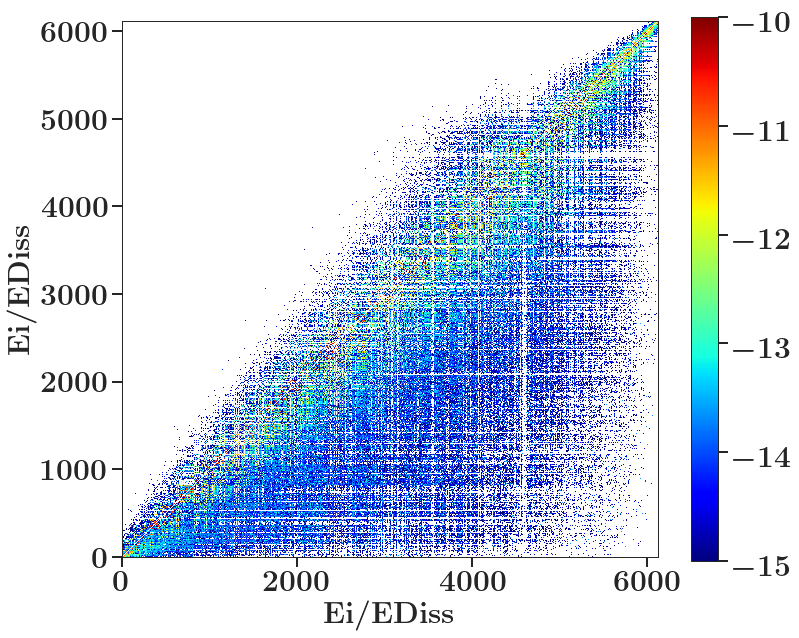

In [12]:
fig, axs = plt.subplots(1,1,sharey=True,sharex=True,figsize=(12,10))
vmin     = -15
vmax     = -10
# extent=[PlotLevelsData['EInt_diss'].min(), PlotLevelsData['EInt_diss'].max(), PlotLevelsData['EInt_diss'].min(),PlotLevelsData['EInt_diss'].max()]
sc = plt.imshow(np.log10(KInel.transpose()),origin='lower', interpolation='none',vmin=vmin, vmax=vmax, cmap='jet')
cbar = plt.colorbar(sc)
plt.xlabel('\\textbf{Ei/EDiss}')
plt.ylabel('\\textbf{Ei/EDiss}')

<ipython-input-10-5dd3fc7c005e>:5: RuntimeWarning: divide by zero encountered in log10
  sc = plt.imshow(np.log10(KInel.transpose()),origin='lower', interpolation='none',vmin=vmin, vmax=vmax,cmap='jet')


(0.0, 200.0)

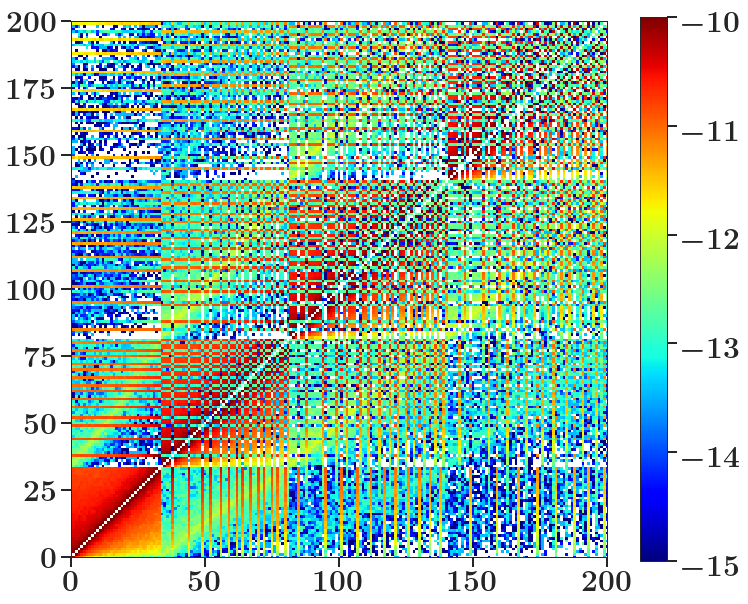

In [10]:
fig, axs = plt.subplots(1,1,sharey=True,sharex=True,figsize=(12,10))
vmin     = -15
vmax     = -10
extent=[PlotLevelsData['EInt_diss'].min(), PlotLevelsData['EInt_diss'].max(), PlotLevelsData['EInt_diss'].min(),PlotLevelsData['EInt_diss'].max()]
sc = plt.imshow(np.log10(KInel.transpose()),origin='lower', interpolation='none',vmin=vmin, vmax=vmax, exntent=extent, cmap='jet')
cbar = plt.colorbar(sc)
plt.xlim([PlotLevelsData['EInt_diss'].min(), PlotLevelsData['EInt_diss'][50]])
plt.ylim([PlotLevelsData['EInt_diss'].min(), PlotLevelsData['EInt_diss'][50]])
plt.xlabel('\\textbf{Ei/EDiss}')
plt.ylabel('\\textbf{Ei/EDiss}')



<ipython-input-14-4a7af39c5fd8>:3: RuntimeWarning: divide by zero encountered in log10
  new2 = new* np.log10(KInel)
<ipython-input-14-4a7af39c5fd8>:3: RuntimeWarning: invalid value encountered in multiply
  new2 = new* np.log10(KInel)


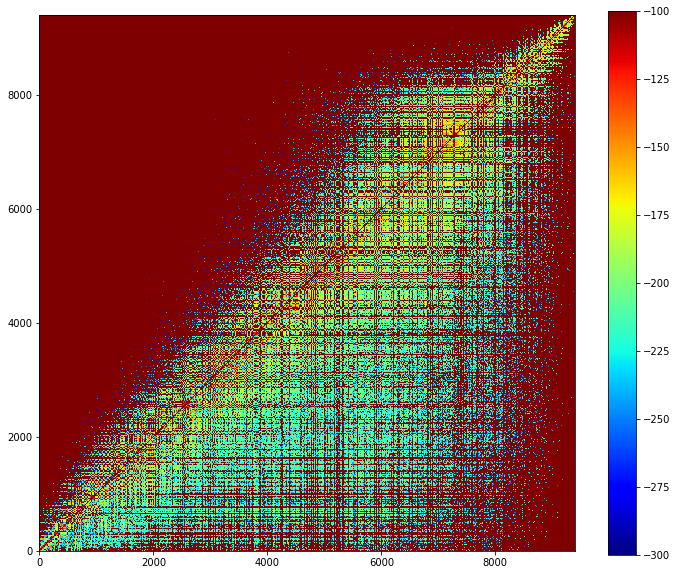

In [14]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
new = np.nan_to_num(ErrorMat)
new2 = new* np.log10(KInel)
new3 = np.nan_to_num(new2)
vmax     = -300
vmin     = -100
sc = plt.imshow(new3.transpose(),origin='lower', interpolation='none', cmap='jet',vmin=vmin, vmax=vmax)
cbar = plt.colorbar(sc)
# # plt.xlim([0,100])
# # plt.ylim([0,100])

In [11]:
np.amax(new)

20.65866892558272

<ipython-input-11-8e8e5376a038>:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(KInel_NN.transpose()),origin='lower', interpolation='none',vmin=vmin, vmax=vmax)


(0.0, 100.0)

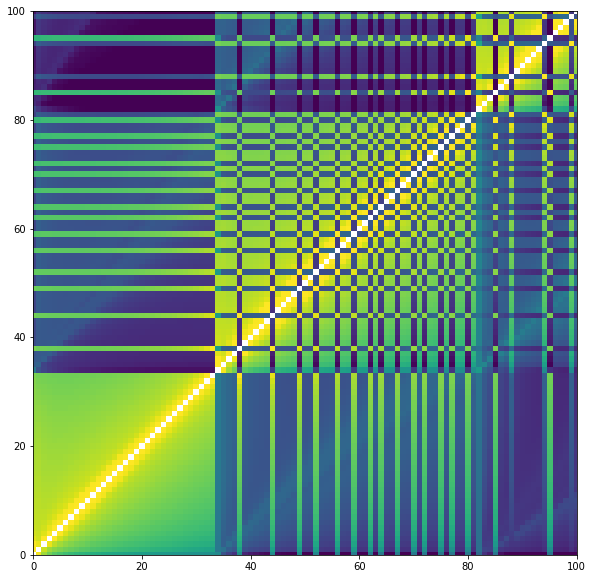

In [11]:
fig, axs = plt.subplots(1,1,figsize=(12,10))
vmax     = -10
vmin     = -15
KInel_NN_plt = KInel_NN.transpose()
# extent=[DiatData[0]['EInt'].min(), DiatData[0]['EInt'].max(), DiatData[0]['EInt'].min(),DiatData[0]['EInt'].max()]
plt.imshow(np.log10(KInel_NN.transpose()),origin='lower', interpolation='none',vmin=vmin, vmax=vmax)
plt.xlim([0,100])
plt.ylim([0,100])


<ipython-input-12-470055e89577>:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(KInel.transpose()),origin='lower', interpolation='none',vmin=vmin, vmax=vmax)


([<matplotlib.axis.YTick at 0x7fb325fb2fd0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

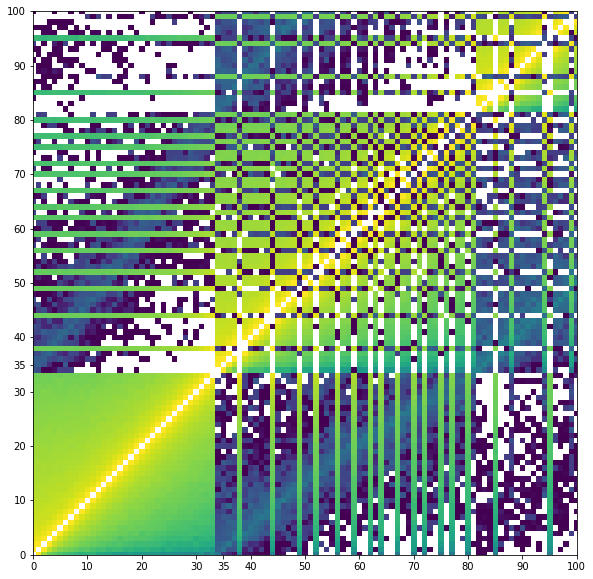

In [12]:
fig, axs = plt.subplots(1,1,figsize=(12,10))
vmax     = -10
vmin     = -15
KInel_NN_plt = KInel_NN.transpose()
# extent=[DiatData[0]['EInt'].min(), DiatData[0]['EInt'].max(), DiatData[0]['EInt'].min(),DiatData[0]['EInt'].max()]
plt.imshow(np.log10(KInel.transpose()),origin='lower', interpolation='none',vmin=vmin, vmax=vmax)
plt.xlim([0,100])
plt.ylim([0,100])
plt.xticks([0,10,20,30,35,40,50,60,70,80,90,100])
plt.yticks([0,10,20,30,35,40,50,60,70,80,90,100])


In [11]:
maxError_perState = np.amax(new,axis=1)
maxError_State = np.argmax(new)
sumError = np.sum(new,axis=1)

/home/venturi/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


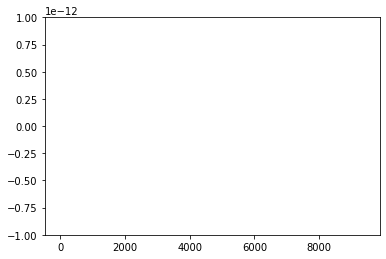

In [13]:
plt.scatter(range(NLevels[0]),maxError_perState)
# plt.ylim([10,25])

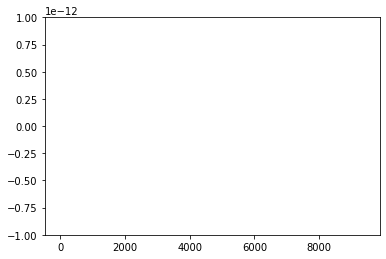

In [14]:
plt.scatter(range(NLevels[0]),maxError_perState)
# plt.ylim([10,25])

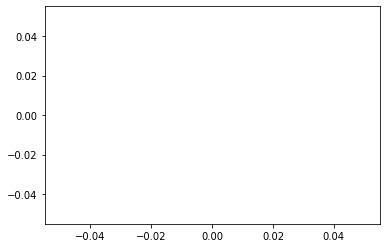

In [15]:
plt.scatter(range(NLevels[0]),sumError)
# plt.ylim([10,25])

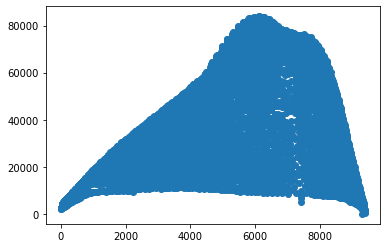

In [14]:
plt.scatter(range(NLevels[0]),sumError)
# plt.ylim([10,25])

In [26]:
maxError_State = np.argmax(a)

In [30]:
9573295/9399

1018.5439940419194

In [31]:
1018*9399 -9573295

-5113